In [13]:
# ---- Setup & imports (biking 3-variant inference test) ----
import os
import sys
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import plotly.io as pio
import torch

# Ensure "src/" is on sys.path so "import project" works (src-layout repo).
def add_src_to_path():
    p = Path.cwd().resolve()
    for parent in [p] + list(p.parents):
        if (parent / "src" / "project").exists():
            src = parent / "src"
            if str(src) not in sys.path:
                sys.path.insert(0, str(src))
            print("Using src:", src)
            return
    raise RuntimeError("Could not locate src/project. Start Jupyter somewhere inside the repo tree.")

add_src_to_path()

from project.utils.dataset import derive_features
from project.utils.modeling import predict_model
from project.utils.visuals import plot_target_vs_predicted_heartrate

pio.renderers.default = "svg"

def read_parquet_pylist(path: Path) -> pd.DataFrame:
    """Robust reader for list-columns without pandas/pyarrow extension dtype issues."""
    table = pq.read_table(path, use_pandas_metadata=False)
    return pd.DataFrame({c: table[c].to_pylist() for c in table.column_names})

def flatten_true_pred(df: pd.DataFrame, true_col="heart_rate", pred_col="predicted_heart_rate", skip_first=True):
    yt_all, yp_all = [], []
    for _, row in df.iterrows():
        yt = np.asarray(row[true_col], dtype=float)
        yp = np.asarray(row[pred_col], dtype=float)
        n = min(len(yt), len(yp))
        if n <= 1:
            continue
        start = 1 if skip_first else 0
        yt_all.append(yt[start:n])
        yp_all.append(yp[start:n])
    if not yt_all:
        return np.asarray([]), np.asarray([])
    return np.concatenate(yt_all), np.concatenate(yp_all)

def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray):
    if y_true.size == 0:
        return float("nan"), float("nan"), 0
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    return mae, rmse, int(y_true.size)

def apply_user_standard_scaler_to_sequences(df, scaler, id_col="userId"):
    """
    Creates *_standardized columns for list-valued signals using scaler.user_stats.
    Supports common layouts:
      A) user_stats[col][user] = (mean, std) or {"mean":..,"std":..}
      B) user_stats[user][col] = (mean, std) or {"mean":..,"std":..}
    """
    if not hasattr(scaler, "user_stats"):
        raise TypeError("Expected scaler.user_stats to exist.")

    df = df.copy()
    raw_cols = ["time_elapsed", "altitude", "derived_speed", "derived_distance", "heart_rate"]

    us = scaler.user_stats

    def get_mu_sigma(user, col):
        # Layout A: user_stats[col][user]
        if isinstance(us, dict) and col in us and isinstance(us[col], dict) and user in us[col]:
            v = us[col][user]
        # Layout B: user_stats[user][col]
        elif isinstance(us, dict) and user in us and isinstance(us[user], dict) and col in us[user]:
            v = us[user][col]
        else:
            # If user/col missing, fall back to neutral scaling
            return 0.0, 1.0

        # v can be (mean,std) or {"mean":..,"std":..}
        if isinstance(v, dict):
            mu = float(v.get("mean", 0.0))
            sig = float(v.get("std", 1.0))
        elif isinstance(v, (tuple, list)) and len(v) == 2:
            mu = float(v[0])
            sig = float(v[1])
        else:
            # Unknown structure
            return 0.0, 1.0

        if not np.isfinite(sig) or sig <= 1e-12:
            sig = 1.0
        if not np.isfinite(mu):
            mu = 0.0
        return mu, sig

    users = df[id_col].tolist()

    for col in raw_cols:
        out = []
        for u, seq in zip(users, df[col].tolist()):
            mu, sig = get_mu_sigma(u, col)
            arr = np.asarray(seq, dtype=float)
            out.append(((arr - mu) / sig).tolist())
        df[f"{col}_standardized"] = out

    return df


Using src: D:\Masters\Data_prep\data-preparation-2026-group-project\src


for biking dataset

In [14]:
# ---- Paths (biking artifacts) ----
# Notebook CWD is typically: .../src/project/notebooks
# We want: .../src/project/temp/biking
BASE = Path.cwd().resolve().parent / "temp" / "biking"

paths = {
    "baseline":  BASE / "biking_test_raw.parquet",
    "corrupted": BASE / "biking_test_raw_corrupted.parquet",
    "cleaned":   BASE / "biking_test_raw_corrupted_cleaned.parquet",
}

STANDARD_SCALER_PATH = BASE / "biking_user_standard_scaler.pkl"
STATIC_ENCODER_PATH  = BASE / "biking_static_ordinal_encoder.pkl"
MODEL_PATH           = BASE / "biking_fitrec_model.pt"

# THESE SHOULD MATCH THE ONES USED DURING TRAINING
dataset_arguments = {
    "numerical_columns": [
        "time_elapsed_standardized",
        "altitude_standardized",
        "derived_speed_standardized",
        "derived_distance_standardized",
    ],
    "categorical_columns": ["userId_idx", "sport_idx", "gender_idx"],
    "heartrate_input_column": "heart_rate_standardized",
    "heartrate_output_column": "heart_rate",
    "workout_id_column": "id",
    "use_heartrate_input": True,
}

print("BASE:", BASE)
for k, v in paths.items():
    print(k, "->", v)

BASE: D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\biking
baseline -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw.parquet
corrupted -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw_corrupted.parquet
cleaned -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\biking\biking_test_raw_corrupted_cleaned.parquet


for running

In [15]:
# ---- Paths (running artifacts) ----
# Notebook CWD is typically: .../src/project/notebooks
# We want: .../src/project/temp/running
BASE = Path.cwd().resolve().parent / "temp" / "running"

paths = {
    "baseline":  BASE / "running_test_raw.parquet",
    "corrupted": BASE / "running_test_raw_corrupted.parquet",
    "cleaned":   BASE / "running_test_raw_corrupted_cleaned.parquet",
}

STANDARD_SCALER_PATH = BASE / "running_user_standard_scaler.pkl"
STATIC_ENCODER_PATH  = BASE / "running_static_ordinal_encoder.pkl"
MODEL_PATH           = BASE / "running_fitrec_model.pt"

# THESE SHOULD MATCH THE ONES USED DURING TRAINING
dataset_arguments = {
    "numerical_columns": [
        "time_elapsed_standardized",
        "altitude_standardized",
        "derived_speed_standardized",
        "derived_distance_standardized",
    ],
    "categorical_columns": ["userId_idx", "sport_idx", "gender_idx"],
    "heartrate_input_column": "heart_rate_standardized",
    "heartrate_output_column": "heart_rate",
    "workout_id_column": "id",
    "use_heartrate_input": True,
}

print("BASE:", BASE)
for k, v in paths.items():
    print(k, "->", v)

BASE: D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\running
baseline -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\running\running_test_raw.parquet
corrupted -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\running\running_test_raw_corrupted.parquet
cleaned -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\running\running_test_raw_corrupted_cleaned.parquet


for walking

In [28]:
# ---- Paths (running artifacts) ----
# Notebook CWD is typically: .../src/project/notebooks
# We want: .../src/project/temp/walking
BASE = Path.cwd().resolve().parent / "temp" / "walking"

paths = {
    "baseline":  BASE / "walking_test_raw.parquet",
    "corrupted0": BASE / "CLEANED_walking_test_raw0.parquet",
    "cleaned0":   BASE / "CLEANED_walking_test_raw0.parquet",
    "corrupted1": BASE / "ERRONOUS_walking_test_raw1.parquet",
    "cleaned1":   BASE / "CLEANED_walking_test_raw1.parquet",
    "corrupted2": BASE / "ERRONOUS_walking_test_raw2.parquet",
    "cleaned2":   BASE / "CLEANED_walking_test_raw2.parquet",
    "corrupted3": BASE / "ERRONOUS_walking_test_raw3.parquet",
    "cleaned3":   BASE / "CLEANED_walking_test_raw3.parquet",
}

STANDARD_SCALER_PATH = BASE / "walking_user_standard_scaler.pkl"
STATIC_ENCODER_PATH  = BASE / "walking_static_ordinal_encoder.pkl"
MODEL_PATH           = BASE / "walking_fitrec_model.pt"

# THESE SHOULD MATCH THE ONES USED DURING TRAINING
dataset_arguments = {
    "numerical_columns": [
        "time_elapsed_standardized",
        "altitude_standardized",
        "derived_speed_standardized",
        "derived_distance_standardized",
    ],
    "categorical_columns": ["userId_idx", "sport_idx", "gender_idx"],
    "heartrate_input_column": "heart_rate_standardized",
    "heartrate_output_column": "heart_rate",
    "workout_id_column": "id",
    "use_heartrate_input": True,
}

print("BASE:", BASE)
for k, v in paths.items():
    print(k, "->", v)

BASE: D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking
baseline -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking\walking_test_raw.parquet
corrupted0 -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking\CLEANED_walking_test_raw0.parquet
cleaned0 -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking\CLEANED_walking_test_raw0.parquet
corrupted1 -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking\ERRONOUS_walking_test_raw1.parquet
cleaned1 -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking\CLEANED_walking_test_raw1.parquet
corrupted2 -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking\ERRONOUS_walking_test_raw2.parquet
cleaned2 -> D:\Masters\Data_prep\data-preparation-2026-group-project\src\project\temp\walking\CLEANED_walking_test_raw2.parquet
corrupted3 -> D:\

In [17]:
# ---- Existence checks ----
assert BASE.exists(), f"BASE does not exist: {BASE}"
assert STANDARD_SCALER_PATH.exists(), f"Missing scaler: {STANDARD_SCALER_PATH}"
assert STATIC_ENCODER_PATH.exists(), f"Missing encoder: {STATIC_ENCODER_PATH}"
assert MODEL_PATH.exists(), f"Missing model: {MODEL_PATH}"

for name, p in paths.items():
    assert p.exists(), f"Missing {name} parquet: {p}"

print("All required files found.")

AttributeError: 'str' object has no attribute 'exists'

In [20]:
# ---- Load artifacts ----
standard_scaler = pickle.load(open(STANDARD_SCALER_PATH, "rb"))
static_encoder  = pickle.load(open(STATIC_ENCODER_PATH, "rb"))

model = torch.load(MODEL_PATH, weights_only=False, map_location="cpu")
model.eval()

print("Loaded scaler:", type(standard_scaler))
print("Loaded encoder:", type(static_encoder))
print("Loaded model:", type(model))

Loaded scaler: <class 'project.utils.dataset.preprocessing.UserStandardScaler'>
Loaded encoder: <class 'project.utils.dataset.preprocessing.StaticFeatureOrdinalEncoder'>
Loaded model: <class 'project.utils.modeling.model.FitRecModel'>


In [43]:
# ---- Run inference for each variant and compute metrics ----
def run_variant(name: str, parquet_path: Path):
    df = read_parquet_pylist(parquet_path)

    # Derive extra features (distance/speed etc.)
    df = derive_features(df)

    # Standardize sequences (robust to list-columns)
    df = apply_user_standard_scaler_to_sequences(df, standard_scaler, id_col="userId")

    # Encode static categorical features -> *_idx
    df = static_encoder.transform(df)

    # Contract check before inference
    required = set(
        dataset_arguments["numerical_columns"]
        + dataset_arguments["categorical_columns"]
        + [
            dataset_arguments["heartrate_input_column"],
            dataset_arguments["heartrate_output_column"],
            dataset_arguments["workout_id_column"],
        ]
    )
    missing = required.difference(df.columns)
    assert not missing, f"[{name}] Missing required columns after preprocessing: {missing}"

    # Predict
    y_preds = predict_model(model, df, dataset_args=dataset_arguments, n_workers=8)
    df["predicted_heart_rate"] = list(y_preds)

    # Score (skip first step due to autoregressive HR input)
    y_true, y_pred = flatten_true_pred(df, skip_first=True)
    mae, rmse, n_points = compute_metrics(y_true, y_pred)

    return df, {"variant": name, "MAE": mae, "RMSE": rmse, "n_points": n_points}

dfs = {}
rows = []
for name, p in paths.items():
    df_out, metrics = run_variant(name, p)
    dfs[name] = df_out
    rows.append(metrics)

results_df = pd.DataFrame(rows).sort_values("variant")
results_df

100%|██████████| 300/300 [00:19<00:00, 15.35it/s] 


,variant,MAE,RMSE,n_points
0,baseline,3.130708,5.492617,89401
2,cleaned0,3.182313,5.522373,89401
4,cleaned1,3.219102,5.561342,89401
6,cleaned2,3.303708,5.631488,89401
8,cleaned3,3.436762,5.805791,89401
1,corrupted0,3.182313,5.522373,89401
3,corrupted1,3.748646,6.308966,89401
5,corrupted2,4.174339,6.864748,89401
7,corrupted3,4.527800,7.248479,89401


Variant: baseline (workout index 0)


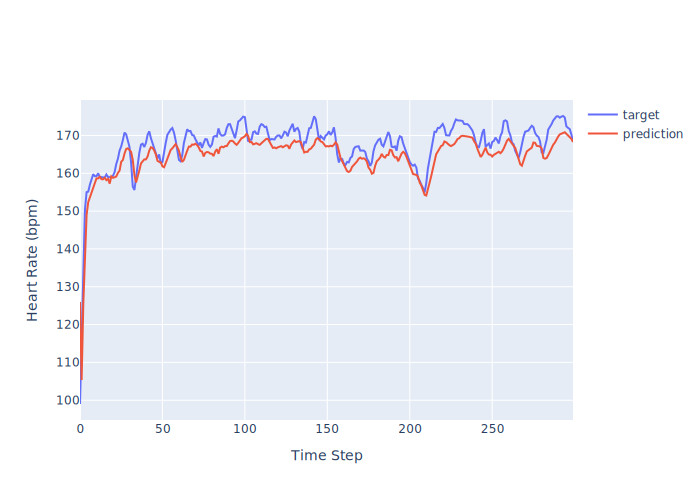

Variant: corrupted0 (workout index 0)


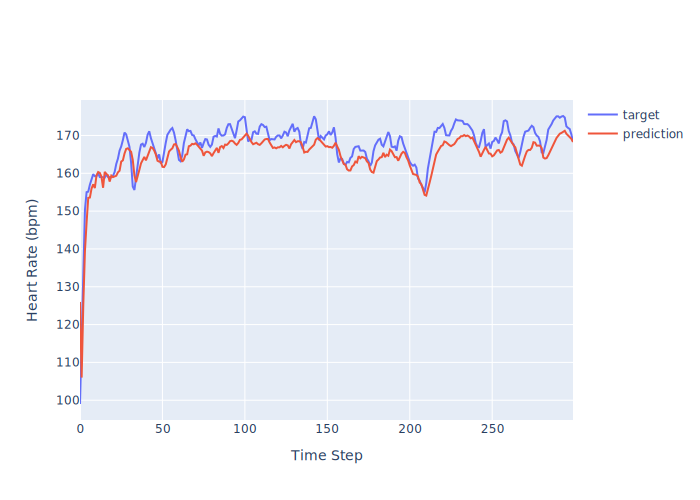

Variant: cleaned0 (workout index 0)


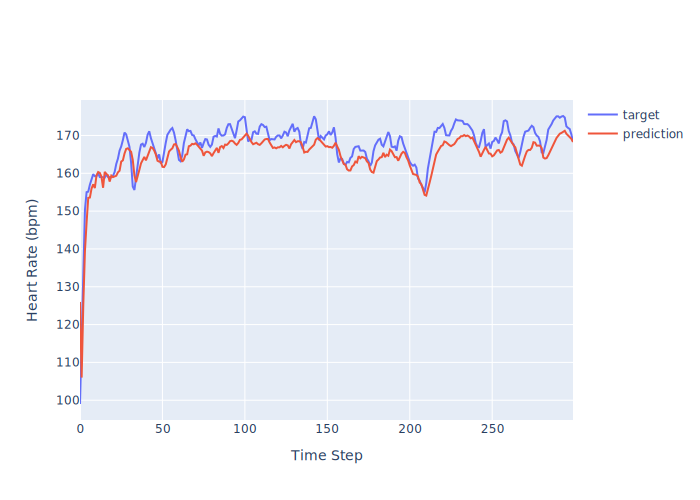

Variant: corrupted1 (workout index 0)


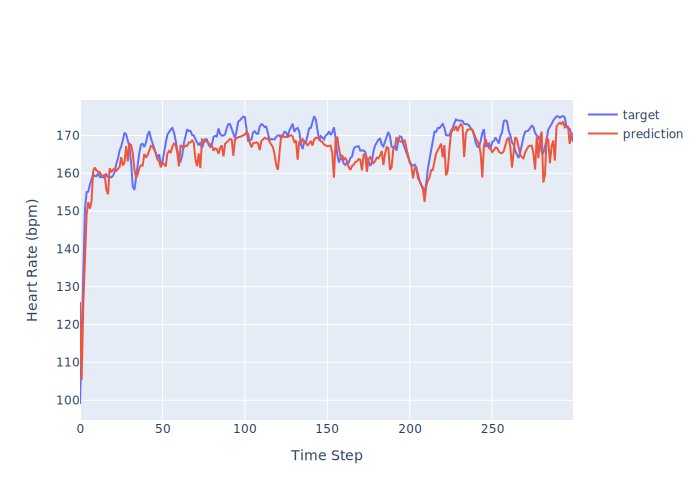

Variant: cleaned1 (workout index 0)


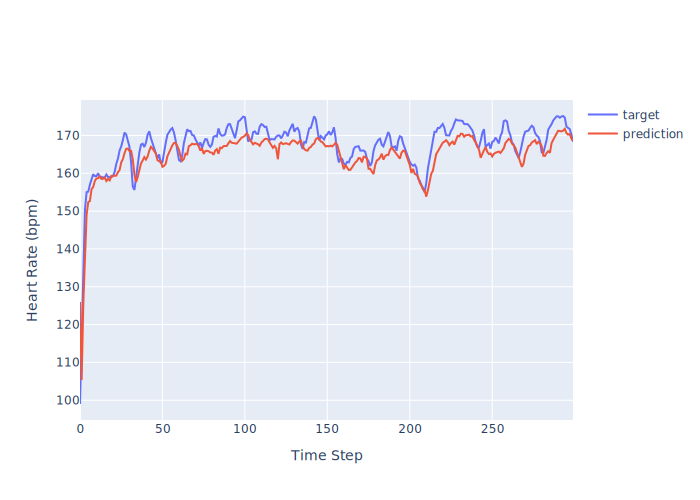

Variant: corrupted2 (workout index 0)


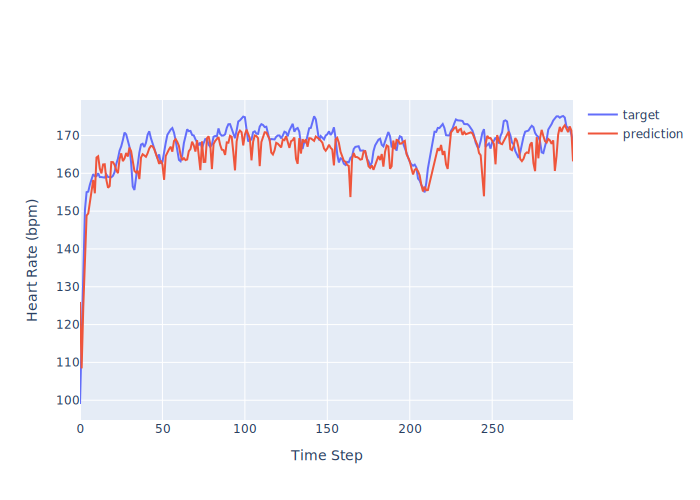

Variant: cleaned2 (workout index 0)


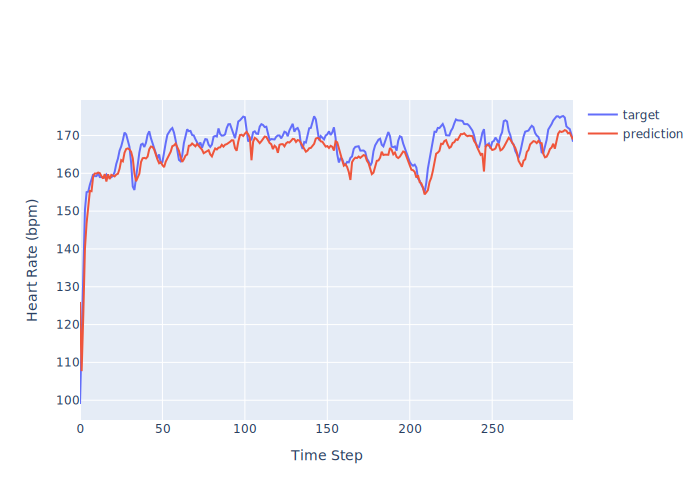

Variant: corrupted3 (workout index 0)


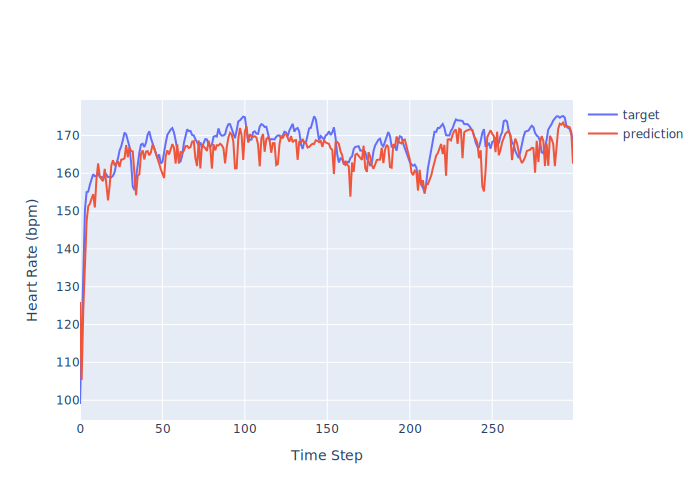

Variant: cleaned3 (workout index 0)


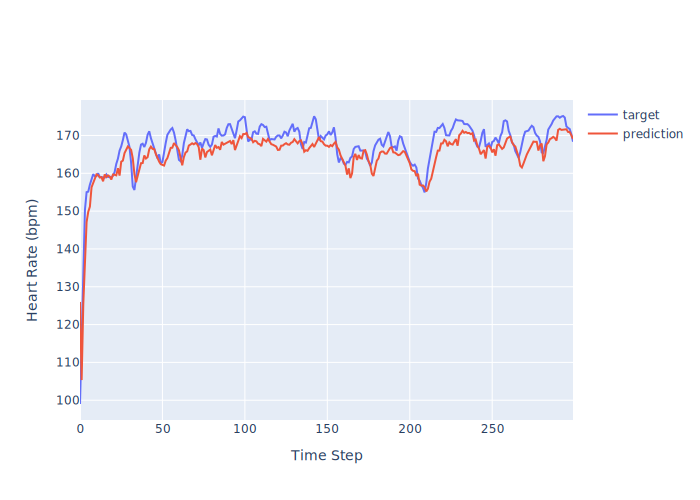

In [46]:
# ---- Plot an example workout for each variant (same row index) ----
index = 0

for name, df in dfs.items():
    heart_rate = df.iloc[index]["heart_rate"]
    heart_rate_preds = df.iloc[index]["predicted_heart_rate"]
    print(f"Variant: {name} (workout index {index})")
    plot_target_vs_predicted_heartrate(heart_rate, heart_rate_preds).show()